In [1]:
!wget http://www.soshnikov.com/permanent/data/petfaces.tar.gz
!tar xfz petfaces.tar.gz
!rm petfaces.tar.gz

--2023-05-18 17:53:13--  http://www.soshnikov.com/permanent/data/petfaces.tar.gz
Resolving www.soshnikov.com (www.soshnikov.com)... 79.137.227.122
Connecting to www.soshnikov.com (www.soshnikov.com)|79.137.227.122|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 24483412 (23M) [application/x-tar]
Saving to: ‘petfaces.tar.gz’

petfaces.tar.gz     100%[===================>]  23.35M   199KB/s    in 2m 6s   

2023-05-18 17:55:19 (190 KB/s) - ‘petfaces.tar.gz’ saved [24483412/24483412]



In [2]:
import pickle
import numpy as np
from skimage import io
import torch

from tqdm import tqdm, tqdm_notebook
from PIL import Image
from pathlib import Path

from torchvision import transforms
from multiprocessing.pool import ThreadPool
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn

from matplotlib import colors, pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings(action='ignore', category=DeprecationWarning)

In [3]:
DATA_MODES = ['train', 'val', 'test']
RESCALE_SIZE = 224

DEVICE = torch.device("cuda")
if torch.cuda.is_available:
  print("cuda")
else: print("cpu")

cuda


Опишем свой класса датасета для работы с изображениями

In [4]:
class PetFacesDataset(Dataset):
    def __init__(self, files, mode, task="bin"):
        super().__init__()
        self.files = sorted(files)
        self.mode = mode
        self.task = task

        if self.mode not in DATA_MODES:
            print(f"{self.mode} is not correct; correct modes: {DATA_MODES}")
            raise NameError

        self.len_ = len(self.files)
     
        self.label_encoder = LabelEncoder()

        if self.mode != 'test':
            if self.task == "bin":
                self.labels = [path.parent.name[0:3] for path in self.files]
                self.label_encoder.fit(self.labels)
                with open('label_encoder.pkl', 'wb') as le_dump_file:
                    pickle.dump(self.label_encoder, le_dump_file)
                
            else:
                self.labels = [path.parent.name for path in self.files]
                self.label_encoder.fit(self.labels)
                with open('label_encoder.pkl', 'wb') as le_dump_file:
                    pickle.dump(self.label_encoder, le_dump_file)

                      
    def __len__(self):
        return self.len_
      
    def load_sample(self, file):
        image = Image.open(file)
        image.load()
        return image
  
    def __getitem__(self, index):
        transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) 
        ])
        x = self.load_sample(self.files[index])
        x = self._prepare_sample(x)
        x = np.array(x / 255, dtype='float32')
        x = transform(x)
        if self.mode == 'test':
            return x
        else:
            label = self.labels[index]
            label_id = self.label_encoder.transform([label])
            y = label_id.item()
            return x, y
        
    def _prepare_sample(self, image):
        image = image.resize((RESCALE_SIZE, RESCALE_SIZE))
        return np.array(image)

In [5]:
DIR = Path('petfaces')
task = "bin"
files = sorted(list(DIR.rglob('*.jpg')))

Разделяем данные на тестовые и тренировочные, выбирая в качестве меток 3 символа названия папок(они соответствуют "cat" и "dog", то есть задаче бинарной классификации)

In [6]:
from sklearn.model_selection import train_test_split

y = [path.parent.name[0:3] for path in files]

train_data, test_data = train_test_split(files, train_size=0.8, stratify=y)

In [7]:
train_dataset = PetFacesDataset(train_data, "train")
test_dataset = PetFacesDataset(test_data, "val")

Опишем нейросеть, перечислением её слоёв

In [8]:
class NetWork(nn.Module):
  def __init__(self):
    super(NetWork, self).__init__()
    self.batch1 = nn.BatchNorm2d(3)
    self.conv1 = nn.Conv2d(3, 6, 3)
    self.pool1 = nn.MaxPool2d(kernel_size=4)
    self.batch2 = nn.BatchNorm2d(6)
    self.conv2 = nn.Conv2d(6, 12, 3)
    self.pool2 = nn.MaxPool2d(kernel_size=4)
    self.batch3 = nn.BatchNorm2d(12)

    #self.conv3 = nn.Conv2d(12, 24, 3)
    #self.pool3 = nn.MaxPool2d(kernel_size=2)
    #self.batch4 = nn.BatchNorm2d(24)
    #self.conv4 = nn.Conv2d(90, 90, 7)
    #self.pool4 = nn.MaxPool2d(kernel_size=2)
    self.fl = nn.Flatten()
    #self.dp1 = nn.Dropout(0.6) # 0.7
    self.fc1 = nn.Linear(169 * 12, 128)
    self.dp2 = nn.Dropout(0.5) # 0.7
    self.activation1 = nn.LeakyReLU()
    #self.fc2 = nn.Linear(128, 128)
    #self.activation2 = nn.ELU()
    self.fc2 = nn.Linear(128, 2)
    #self.sm = nn.Softmax(dim=0)


  def forward(self, x):
    x = self.pool1(self.conv1(self.batch1(x)))
    x = self.pool2(self.conv2(self.batch2(x)))
    x = self.batch3(x)
    #x += identity
    #x = self.batch2(x)
    #x = self.batch4(x)
    #x = self.pool4(self.conv4(self.batch4(x)))
    x = self.fl(x)
    #x = self.dp1(x)
    x = self.activation1(self.dp2(self.fc1(x)))
    #x = self.activation2(self.fc2(x))
    #x = self.sm(x)
    #x = self.sm(self.fc3(x))
    x = self.fc2(x)
    return x


model = NetWork()
model = model.to(DEVICE)


Опишем функции для обучения и тестирования модели

In [9]:
def fit_epoch(model, train_loader, criterion, optimizer):
    model.train()
    running_loss = 0.0
    running_corrects = 0
    processed_data = 0
  
    for inputs, labels in train_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        preds = torch.argmax(outputs, 1)
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_data += inputs.size(0)
              
    train_loss = running_loss / processed_data
    train_acc = running_corrects.cpu().numpy() / processed_data
    return train_loss, train_acc

In [10]:
def eval_epoch(model, val_loader, criterion):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    corrects_top3 = 0
    processed_size = 0
    predictions = []
    answers = []
    for inputs, labels in val_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)
        with torch.set_grad_enabled(False):
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            preds = torch.argmax(outputs, 1)
            top3_preds = preds
            if preds.ndim > 1:
                _, top3_preds = torch.topk(outputs, k=3, dim=1)

        running_loss += loss.item() * inputs.size(0)
        for index in range(0, len(labels.data)):
          if labels.data[index] in top3_preds[index]:
            corrects_top3 += 1
        running_corrects += torch.sum(preds == labels.data)
        for pred in preds:
          predictions.append(int(pred))
        for label in labels.data:
          answers.append(int(label))
        processed_size += inputs.size(0)
    val_loss = running_loss / processed_size
    val_acc = running_corrects.double() / processed_size
    val_acc_top3 = float(corrects_top3) / processed_size
    return val_loss, val_acc, val_acc_top3, predictions, answers

In [11]:
def train(train_dataset, test_dataset, model, epochs, batch_size):
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    history = []
    predictions = []
    log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f} \
    val_loss {v_loss:0.4f} train_acc {t_acc:0.4f} val_acc {v_acc:0.4f} val_acc_top3 {v_acc_top3:0.4f}"

    with tqdm(desc="epoch", total=epochs) as pbar_outer:
        opt = torch.optim.Adam(model.parameters())
        scheduler = torch.optim.lr_scheduler.ExponentialLR(opt,
          gamma=0.95)
        criterion = nn.CrossEntropyLoss()

        for epoch in range(epochs):
            train_loss, train_acc = fit_epoch(model, train_loader, criterion, opt)
            scheduler.step()
            val_loss, val_acc, val_acc_top3, predictions, answers = eval_epoch(model, val_loader, criterion)
            history.append((train_loss, train_acc, val_loss, val_acc))
            
            pbar_outer.update(1)
            tqdm.write(log_template.format(ep=epoch+1, t_loss=train_loss,\
                                           v_loss=val_loss, t_acc=train_acc, v_acc=val_acc, v_acc_top3=val_acc_top3))
            
    return history, predictions, answers

In [12]:
def predict(model, test_loader):
    with torch.no_grad():
        logits = []
        for inputs in test_loader:
            inputs = inputs.to(DEVICE)
            model.eval()
            outputs = model(inputs).cpu()
            logits.append(outputs)
            
    probs = nn.functional.softmax(torch.cat(logits), dim=-1).numpy()
    return probs

**Бинарная классификация**

Обучим и протестируем нашу модель

In [ ]:
history, predictions, answers = train(train_dataset, test_dataset, model=model, epochs=10, batch_size=64)

epoch:  10%|█         | 1/10 [00:14<02:07, 14.15s/it]


Epoch 001 train_loss: 0.1718     val_loss 0.2807 train_acc 0.9283 val_acc 0.8771 val_acc_top3 0.8771


epoch:  20%|██        | 2/10 [00:28<01:53, 14.17s/it]


Epoch 002 train_loss: 0.1316     val_loss 0.2887 train_acc 0.9517 val_acc 0.8818 val_acc_top3 0.8818


epoch:  30%|███       | 3/10 [00:42<01:39, 14.22s/it]


Epoch 003 train_loss: 0.0963     val_loss 0.2229 train_acc 0.9712 val_acc 0.9238 val_acc_top3 0.9238


epoch:  40%|████      | 4/10 [00:57<01:26, 14.36s/it]


Epoch 004 train_loss: 0.0623     val_loss 0.2352 train_acc 0.9790 val_acc 0.9114 val_acc_top3 0.9114


epoch:  50%|█████     | 5/10 [01:11<01:12, 14.47s/it]


Epoch 005 train_loss: 0.0387     val_loss 0.2128 train_acc 0.9879 val_acc 0.9269 val_acc_top3 0.9269


epoch:  60%|██████    | 6/10 [01:26<00:58, 14.56s/it]


Epoch 006 train_loss: 0.0290     val_loss 0.2333 train_acc 0.9934 val_acc 0.9191 val_acc_top3 0.9191


epoch:  70%|███████   | 7/10 [01:40<00:43, 14.49s/it]


Epoch 007 train_loss: 0.0277     val_loss 0.2271 train_acc 0.9922 val_acc 0.9316 val_acc_top3 0.9316


epoch:  80%|████████  | 8/10 [01:55<00:28, 14.45s/it]


Epoch 008 train_loss: 0.0226     val_loss 0.2791 train_acc 0.9942 val_acc 0.9129 val_acc_top3 0.9129


epoch:  90%|█████████ | 9/10 [02:09<00:14, 14.34s/it]


Epoch 009 train_loss: 0.0169     val_loss 0.2300 train_acc 0.9965 val_acc 0.9300 val_acc_top3 0.9300


epoch: 100%|██████████| 10/10 [02:23<00:00, 14.36s/it]


Epoch 010 train_loss: 0.0108     val_loss 0.2457 train_acc 0.9988 val_acc 0.9378 val_acc_top3 0.9378


In [ ]:
loss, acc, val_loss, val_acc = zip(*history)

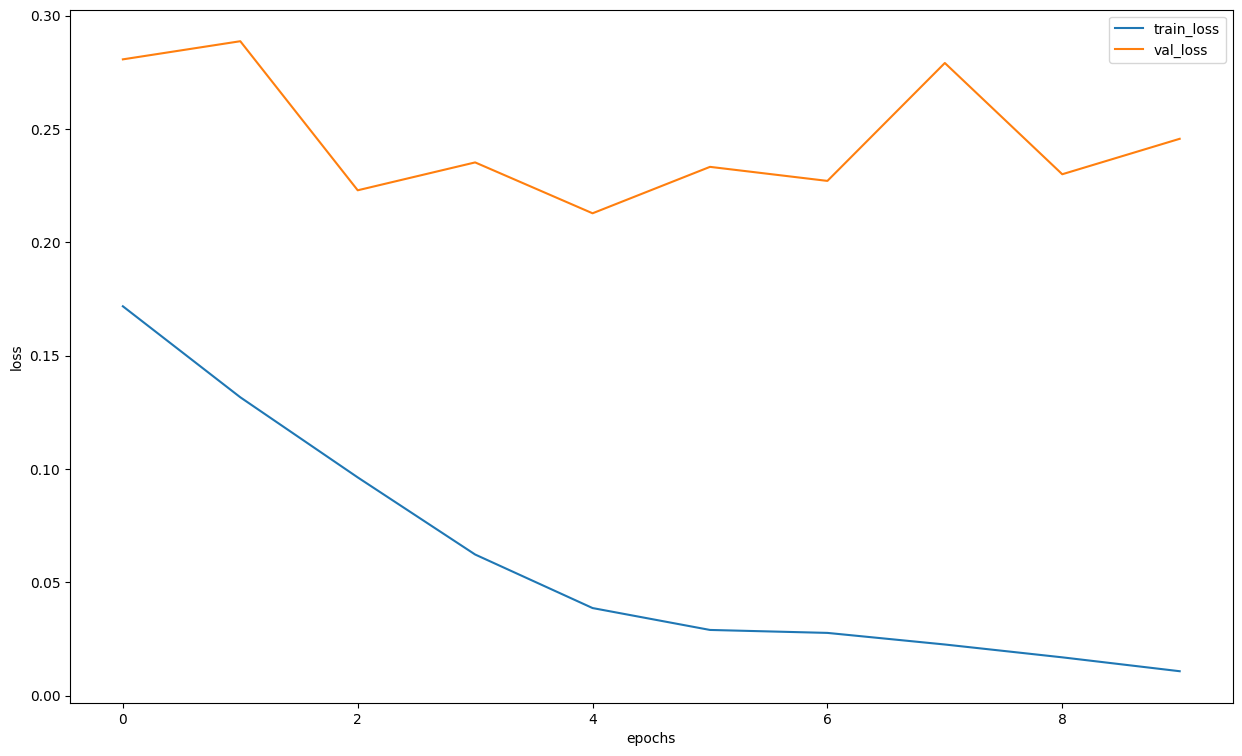

In [ ]:
plt.figure(figsize=(15, 9))
plt.plot(loss, label="train_loss")
plt.plot(val_loss, label="val_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

**Многоклассовая классификация**

Подготовим данные для многоклассовой классификации, сохраняя в качестве меток полные имена папок


In [13]:
from sklearn.model_selection import train_test_split

_y = [path.parent.name for path in files]
train_data_multi, test_data_multi = train_test_split(files, train_size=0.8, stratify=_y)

train_dataset_multi = PetFacesDataset(train_data_multi, "train", task="multi")
test_dataset_multi = PetFacesDataset(test_data_multi, "val", task="multi")

Изменим последний слой модели под задачу многоклассовой классификации

In [14]:
model.fc2 = nn.Linear(128, 35)
model = model.to(DEVICE)

In [ ]:
history_, predictions_, answers_ = train(train_dataset_multi, test_dataset_multi, model=model, epochs=15, batch_size=64)

epoch:   7%|▋         | 1/15 [00:14<03:25, 14.66s/it]


Epoch 001 train_loss: 0.6312     val_loss 1.4984 train_acc 0.8072 val_acc 0.5832 val_acc_top3 0.5832


epoch:  13%|█▎        | 2/15 [00:30<03:16, 15.12s/it]


Epoch 002 train_loss: 0.5212     val_loss 1.4271 train_acc 0.8435 val_acc 0.6096 val_acc_top3 0.6096


epoch:  20%|██        | 3/15 [00:44<02:59, 14.97s/it]


Epoch 003 train_loss: 0.3959     val_loss 1.4751 train_acc 0.8863 val_acc 0.6065 val_acc_top3 0.6065


epoch:  27%|██▋       | 4/15 [00:59<02:43, 14.88s/it]


Epoch 004 train_loss: 0.3475     val_loss 1.5592 train_acc 0.8972 val_acc 0.6050 val_acc_top3 0.6050


epoch:  33%|███▎      | 5/15 [01:14<02:27, 14.72s/it]


Epoch 005 train_loss: 0.3246     val_loss 1.4927 train_acc 0.9065 val_acc 0.6065 val_acc_top3 0.6065


epoch:  40%|████      | 6/15 [01:28<02:11, 14.63s/it]


Epoch 006 train_loss: 0.2599     val_loss 1.5320 train_acc 0.9295 val_acc 0.6252 val_acc_top3 0.6252


epoch:  47%|████▋     | 7/15 [01:46<02:05, 15.65s/it]


Epoch 007 train_loss: 0.2293     val_loss 1.4961 train_acc 0.9381 val_acc 0.6221 val_acc_top3 0.6221


epoch:  53%|█████▎    | 8/15 [02:01<01:48, 15.46s/it]


Epoch 008 train_loss: 0.2163     val_loss 1.5795 train_acc 0.9443 val_acc 0.6174 val_acc_top3 0.6174


epoch:  60%|██████    | 9/15 [02:16<01:31, 15.22s/it]


Epoch 009 train_loss: 0.1751     val_loss 1.5435 train_acc 0.9537 val_acc 0.6096 val_acc_top3 0.6096


epoch:  67%|██████▋   | 10/15 [02:30<01:14, 14.98s/it]


Epoch 010 train_loss: 0.1556     val_loss 1.5853 train_acc 0.9622 val_acc 0.6205 val_acc_top3 0.6205


epoch:  73%|███████▎  | 11/15 [02:44<00:59, 14.83s/it]


Epoch 011 train_loss: 0.1354     val_loss 1.5580 train_acc 0.9653 val_acc 0.6221 val_acc_top3 0.6221


epoch:  80%|████████  | 12/15 [02:59<00:44, 14.68s/it]


Epoch 012 train_loss: 0.1438     val_loss 1.5965 train_acc 0.9607 val_acc 0.6221 val_acc_top3 0.6221


epoch:  87%|████████▋ | 13/15 [03:15<00:30, 15.09s/it]


Epoch 013 train_loss: 0.1350     val_loss 1.6291 train_acc 0.9681 val_acc 0.6112 val_acc_top3 0.6112


epoch:  93%|█████████▎| 14/15 [03:30<00:15, 15.12s/it]


Epoch 014 train_loss: 0.1167     val_loss 1.6089 train_acc 0.9735 val_acc 0.6345 val_acc_top3 0.6345


epoch: 100%|██████████| 15/15 [03:45<00:00, 15.06s/it]


Epoch 015 train_loss: 0.1011     val_loss 1.6278 train_acc 0.9770 val_acc 0.6252 val_acc_top3 0.6252


**Creating confusion matrix**










In [ ]:
import numpy as np
classes = list(np.unique(_y))
classes
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd
len(classes)

35

Строка отвечает за правильный ответ, то есть за метку класса, к которому принадлежит объект, а столбец за прогноз модели, тогда на пересечении столбца и строки будет стоять число объектов, для которых класс соответствует строке, а прогноз модели-столбцу

In [ ]:
cf_matrix = confusion_matrix(answers_, predictions_)
df_cm = pd.DataFrame(cf_matrix, index=classes, columns=classes)
df_cm

,cat_Abyssinian,cat_Bengal,cat_Birman,cat_Bombay,cat_British,cat_Egyptian,cat_Maine,cat_Persian,cat_Ragdoll,cat_Russian,...,dog_newfoundland,dog_pomeranian,dog_pug,dog_saint,dog_samoyed,dog_scottish,dog_shiba,dog_staffordshire,dog_wheaten,dog_yorkshire
cat_Abyssinian,11,3,0,0,0,0,0,1,1,0,...,0,0,0,0,0,0,0,0,0,0
cat_Bengal,2,6,1,0,0,3,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
cat_Birman,0,0,17,0,0,0,0,1,1,0,...,0,0,0,0,0,0,0,0,0,0
cat_Bombay,0,0,0,15,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
cat_British,0,0,0,1,19,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
cat_Egyptian,0,3,0,1,1,7,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
cat_Maine,2,2,0,0,0,0,14,0,0,0,...,0,0,0,0,0,0,0,0,0,1
cat_Persian,0,0,1,0,0,0,0,18,0,0,...,0,0,0,0,0,0,0,0,0,0
cat_Ragdoll,0,0,2,0,0,0,0,2,12,0,...,0,0,0,0,0,0,0,0,0,0
cat_Russian,0,0,0,0,5,0,0,0,0,13,...,0,0,0,0,0,0,0,0,0,0


**Выполним оптимизацию гиперпараметоров**

Выбор архитектуры был выполнен ранее. В качестве слоёв были выбраны convolutional слой, maxpool и batchnorm и два полносвязных слоя. Для выбора оптимальной архитектуры я брал сначала четыре таких слоя состоящих из свёртки, пулинга и батчнормы, затем три и два, меняя также размер пулинга и число карт активаций после свёртки. Нейросеть с 3 и 4 свёрточными слоями очень быстро переобучалась, выдавая на тренировочной выборке долю правильных ответов порядка 0.98, в то время как на тестовой выборке это значение не поднималось выше 0.6. Оптимальным с точки зрения количества слоёв оказалось выбирать два таких слоя.
Также в качестве оптимизаторов использовались Adam и AdamW, как лучшие алгоритмы оптимизации. Второй использовался в надежде справиться с переобучением, что частично было достигнуто, однако итоговое качество на тестовой выборке не выросло.


In [15]:
class AdaptiveNetWork(nn.Module):
  def __init__(self, kernel_size=3):
    super(AdaptiveNetWork, self).__init__()
    self.batch1 = nn.BatchNorm2d(3)
    self.conv1 = nn.Conv2d(3, 6, kernel_size)
    self.pool1 = nn.MaxPool2d(kernel_size=4)
    self.batch2 = nn.BatchNorm2d(6)
    self.conv2 = nn.Conv2d(6, 12, kernel_size)
    self.pool2 = nn.MaxPool2d(kernel_size=4)
    self.batch3 = nn.BatchNorm2d(12)
    self.fl = nn.Flatten()
    feature_count = ((224 - kernel_size + 1) // 4 - kernel_size + 1) // 4
    self.fc1 = nn.Linear(feature_count ** 2 * 12, 128)
    self.dp2 = nn.Dropout(0.6) # 0.7
    self.activation1 = nn.LeakyReLU()
    self.fc2 = nn.Linear(128, 35)


  def forward(self, x):
    x = self.pool1(self.conv1(self.batch1(x)))
    x = self.pool2(self.conv2(self.batch2(x)))
    x = self.batch3(x)
    x = self.fl(x)
    x = self.activation1(self.dp2(self.fc1(x)))
    x = self.fc2(x)
    return x

In [16]:
def train_search(train_dataset, test_dataset, model, epochs, batch_size, learning_rate):
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    history = []
    predictions = []
    log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f} \
    val_loss {v_loss:0.4f} train_acc {t_acc:0.4f} val_acc {v_acc:0.4f} val_acc_top3 {v_acc_top3:0.4f}"

    with tqdm(desc="epoch", total=epochs) as pbar_outer:
        opt = torch.optim.Adam(model.parameters(), lr=learning_rate)
        scheduler = torch.optim.lr_scheduler.ExponentialLR(opt,
          gamma=0.95)
        criterion = nn.CrossEntropyLoss()
        for epoch in range(epochs):
            train_loss, train_acc = fit_epoch(model, train_loader, criterion, opt)
            scheduler.step()
            val_loss, val_acc, val_acc_top3, predictions, answers = eval_epoch(model, val_loader, criterion)
            history.append((train_loss, train_acc, val_loss, val_acc))
            
            pbar_outer.update(1)
            tqdm.write(log_template.format(ep=epoch+1, t_loss=train_loss,\
                                           v_loss=val_loss, t_acc=train_acc, v_acc=val_acc, v_acc_top3=val_acc_top3))
            
    return history

Для поиска оптимальных параметров воспользуемся поиском по сетке, то есть переберём все комбинации параметров из некоторой "сетки". Такой подход редко используют при обучении нейронных сетей, так как они долго обучаются и на одной комбинации гиперпараметров, не говоря уже о нескольких. Но в нашем случае обучение занимает пару минут, поэтому вариант перебора возможен.

In [ ]:
from sklearn.model_selection import StratifiedKFold

def grid_search(lr, kernel_sizes):
    split_count = len(lr) * len(kernel_sizes)
    kf = StratifiedKFold(n_splits=split_count)
    best_lr = lr[0]
    best_kernel_size = kernel_sizes[0]
    curr_result = 0.0
    for learning_rate in lr:
        for kernel_size in kernel_sizes:
            X_train, X_val = next(kf.split(files, _y))
            train_data = [files[element] for element in X_train]
            val_data = [files[element] for element in X_val]
            train_dataset = PetFacesDataset(train_data, "train", "multi")
            val_dataset = PetFacesDataset(val_data, "val", "multi")
            search_model = AdaptiveNetWork(kernel_size)
            search_model = search_model.to(DEVICE)
            print("learning_rate=", learning_rate, "kernel_size=", kernel_size)
            history = train_search(train_dataset, val_dataset, search_model, 15, 64, learning_rate)
            result = float(history[-1][3])
            if result > curr_result:
                best_lr = learning_rate
                best_kernel_size = kernel_size
            print("result:", result)
    return best_lr, best_kernel_size

На практике обычно не используют фильтры чётного размера, и современные модели не используют фильтры больше 7 на 7. Поэтому я остановился на фильтрах размерами 3 на 3, 5 на 5 и 7 на 7. Использование батчнормы делает обучение нейросети более стабильным и позволяет брать learning rate больше, что мы и сделаем.

In [ ]:
params = {
    "lr": [0.001, 0.002, 0.004, 0.006, 0.01, 0.05],
    "kernel_sizes": [3, 5, 7]
}

best_params = grid_search(**params)
print(best_params)

learning_rate= 0.001 kernel_size= 3


epoch:   7%|▋         | 1/15 [00:16<03:48, 16.33s/it]


Epoch 001 train_loss: 3.0620     val_loss 2.2351 train_acc 0.1708 val_acc 0.4078 val_acc_top3 0.4078


epoch:  13%|█▎        | 2/15 [00:30<03:18, 15.27s/it]


Epoch 002 train_loss: 2.2407     val_loss 1.9042 train_acc 0.3750 val_acc 0.5140 val_acc_top3 0.5140


epoch:  20%|██        | 3/15 [00:45<02:58, 14.87s/it]


Epoch 003 train_loss: 1.7806     val_loss 1.6348 train_acc 0.4809 val_acc 0.5475 val_acc_top3 0.5475


epoch:  27%|██▋       | 4/15 [00:59<02:41, 14.68s/it]


Epoch 004 train_loss: 1.5090     val_loss 1.4837 train_acc 0.5683 val_acc 0.5698 val_acc_top3 0.5698


epoch:  33%|███▎      | 5/15 [01:15<02:30, 15.00s/it]


Epoch 005 train_loss: 1.2842     val_loss 1.4538 train_acc 0.6247 val_acc 0.5810 val_acc_top3 0.5810


epoch:  40%|████      | 6/15 [01:30<02:15, 15.08s/it]


Epoch 006 train_loss: 1.0992     val_loss 1.3449 train_acc 0.6765 val_acc 0.6201 val_acc_top3 0.6201


epoch:  47%|████▋     | 7/15 [01:46<02:02, 15.28s/it]


Epoch 007 train_loss: 1.0215     val_loss 1.3966 train_acc 0.7038 val_acc 0.6034 val_acc_top3 0.6034


epoch:  53%|█████▎    | 8/15 [02:01<01:46, 15.22s/it]


Epoch 008 train_loss: 0.9114     val_loss 1.3165 train_acc 0.7332 val_acc 0.6034 val_acc_top3 0.6034


epoch:  60%|██████    | 9/15 [02:15<01:30, 15.02s/it]


Epoch 009 train_loss: 0.7703     val_loss 1.3438 train_acc 0.7767 val_acc 0.6145 val_acc_top3 0.6145


epoch:  67%|██████▋   | 10/15 [02:30<01:14, 14.90s/it]


Epoch 010 train_loss: 0.6959     val_loss 1.3168 train_acc 0.7968 val_acc 0.6201 val_acc_top3 0.6201


epoch:  73%|███████▎  | 11/15 [02:45<01:00, 15.05s/it]


Epoch 011 train_loss: 0.6267     val_loss 1.3841 train_acc 0.8156 val_acc 0.5922 val_acc_top3 0.5922


epoch:  80%|████████  | 12/15 [03:00<00:44, 14.89s/it]


Epoch 012 train_loss: 0.5724     val_loss 1.3651 train_acc 0.8400 val_acc 0.5922 val_acc_top3 0.5922


epoch:  87%|████████▋ | 13/15 [03:14<00:29, 14.79s/it]


Epoch 013 train_loss: 0.5147     val_loss 1.3489 train_acc 0.8453 val_acc 0.5978 val_acc_top3 0.5978


epoch:  93%|█████████▎| 14/15 [03:29<00:14, 14.76s/it]


Epoch 014 train_loss: 0.4979     val_loss 1.3725 train_acc 0.8503 val_acc 0.6034 val_acc_top3 0.6034


epoch: 100%|██████████| 15/15 [03:44<00:00, 14.99s/it]



Epoch 015 train_loss: 0.4355     val_loss 1.4375 train_acc 0.8740 val_acc 0.5922 val_acc_top3 0.5922
result: 0.5921787709497207
learning_rate= 0.001 kernel_size= 5


epoch:   7%|▋         | 1/15 [00:17<04:03, 17.37s/it]


Epoch 001 train_loss: 3.1229     val_loss 2.3931 train_acc 0.1544 val_acc 0.3855 val_acc_top3 0.3855


epoch:  13%|█▎        | 2/15 [00:33<03:33, 16.46s/it]


Epoch 002 train_loss: 2.3478     val_loss 1.9620 train_acc 0.3318 val_acc 0.4358 val_acc_top3 0.4358


epoch:  20%|██        | 3/15 [00:49<03:15, 16.28s/it]


Epoch 003 train_loss: 1.8708     val_loss 1.8101 train_acc 0.4631 val_acc 0.4693 val_acc_top3 0.4693


epoch:  27%|██▋       | 4/15 [01:05<03:00, 16.43s/it]


Epoch 004 train_loss: 1.6522     val_loss 1.6673 train_acc 0.5228 val_acc 0.4972 val_acc_top3 0.4972


epoch:  33%|███▎      | 5/15 [01:21<02:42, 16.26s/it]


Epoch 005 train_loss: 1.4185     val_loss 1.6412 train_acc 0.5923 val_acc 0.5140 val_acc_top3 0.5140


epoch:  40%|████      | 6/15 [01:37<02:25, 16.16s/it]


Epoch 006 train_loss: 1.2795     val_loss 1.5492 train_acc 0.6276 val_acc 0.5251 val_acc_top3 0.5251


epoch:  47%|████▋     | 7/15 [01:54<02:09, 16.17s/it]


Epoch 007 train_loss: 1.1037     val_loss 1.5229 train_acc 0.6781 val_acc 0.5754 val_acc_top3 0.5754


epoch:  53%|█████▎    | 8/15 [02:10<01:54, 16.32s/it]


Epoch 008 train_loss: 1.0211     val_loss 1.5463 train_acc 0.6890 val_acc 0.5698 val_acc_top3 0.5698


epoch:  60%|██████    | 9/15 [02:26<01:37, 16.17s/it]


Epoch 009 train_loss: 0.9280     val_loss 1.4665 train_acc 0.7365 val_acc 0.5642 val_acc_top3 0.5642


epoch:  67%|██████▋   | 10/15 [02:41<01:19, 15.93s/it]


Epoch 010 train_loss: 0.8095     val_loss 1.4871 train_acc 0.7586 val_acc 0.5363 val_acc_top3 0.5363


epoch:  73%|███████▎  | 11/15 [02:57<01:03, 15.80s/it]


Epoch 011 train_loss: 0.7191     val_loss 1.4475 train_acc 0.7916 val_acc 0.5475 val_acc_top3 0.5475


epoch:  80%|████████  | 12/15 [03:13<00:47, 15.98s/it]


Epoch 012 train_loss: 0.6549     val_loss 1.4697 train_acc 0.8090 val_acc 0.5866 val_acc_top3 0.5866


epoch:  87%|████████▋ | 13/15 [03:28<00:31, 15.70s/it]


Epoch 013 train_loss: 0.6233     val_loss 1.4832 train_acc 0.8137 val_acc 0.5698 val_acc_top3 0.5698


epoch:  93%|█████████▎| 14/15 [03:44<00:15, 15.56s/it]


Epoch 014 train_loss: 0.5526     val_loss 1.5155 train_acc 0.8397 val_acc 0.5363 val_acc_top3 0.5363


epoch: 100%|██████████| 15/15 [03:59<00:00, 15.96s/it]



Epoch 015 train_loss: 0.5092     val_loss 1.4282 train_acc 0.8536 val_acc 0.5698 val_acc_top3 0.5698
result: 0.5698324022346369
learning_rate= 0.001 kernel_size= 7


epoch:   7%|▋         | 1/15 [00:16<03:49, 16.38s/it]


Epoch 001 train_loss: 3.1851     val_loss 2.5219 train_acc 0.1474 val_acc 0.3575 val_acc_top3 0.3575


epoch:  13%|█▎        | 2/15 [00:31<03:26, 15.90s/it]


Epoch 002 train_loss: 2.4317     val_loss 1.9872 train_acc 0.3176 val_acc 0.4637 val_acc_top3 0.4637


epoch:  20%|██        | 3/15 [00:47<03:10, 15.84s/it]


Epoch 003 train_loss: 2.0192     val_loss 1.7856 train_acc 0.4192 val_acc 0.4972 val_acc_top3 0.4972


epoch:  27%|██▋       | 4/15 [01:04<02:56, 16.03s/it]


Epoch 004 train_loss: 1.7010     val_loss 1.6576 train_acc 0.5082 val_acc 0.5419 val_acc_top3 0.5419


epoch:  33%|███▎      | 5/15 [01:19<02:40, 16.00s/it]


Epoch 005 train_loss: 1.4580     val_loss 1.5019 train_acc 0.5719 val_acc 0.5419 val_acc_top3 0.5419


epoch:  40%|████      | 6/15 [01:35<02:22, 15.85s/it]


Epoch 006 train_loss: 1.2713     val_loss 1.4651 train_acc 0.6263 val_acc 0.5866 val_acc_top3 0.5866


epoch:  47%|████▋     | 7/15 [01:51<02:06, 15.80s/it]


Epoch 007 train_loss: 1.1436     val_loss 1.3896 train_acc 0.6596 val_acc 0.5922 val_acc_top3 0.5922


epoch:  53%|█████▎    | 8/15 [02:08<01:53, 16.24s/it]


Epoch 008 train_loss: 0.9928     val_loss 1.3763 train_acc 0.6976 val_acc 0.6034 val_acc_top3 0.6034


epoch:  60%|██████    | 9/15 [02:24<01:36, 16.04s/it]


Epoch 009 train_loss: 0.8844     val_loss 1.3621 train_acc 0.7365 val_acc 0.5475 val_acc_top3 0.5475


epoch:  67%|██████▋   | 10/15 [02:39<01:19, 15.91s/it]


Epoch 010 train_loss: 0.8436     val_loss 1.3012 train_acc 0.7454 val_acc 0.6034 val_acc_top3 0.6034


epoch:  73%|███████▎  | 11/15 [02:55<01:03, 15.90s/it]


Epoch 011 train_loss: 0.7229     val_loss 1.3238 train_acc 0.7879 val_acc 0.5978 val_acc_top3 0.5978


epoch:  80%|████████  | 12/15 [03:11<00:48, 16.01s/it]


Epoch 012 train_loss: 0.6478     val_loss 1.3082 train_acc 0.8028 val_acc 0.5922 val_acc_top3 0.5922


epoch:  87%|████████▋ | 13/15 [03:27<00:31, 15.86s/it]


Epoch 013 train_loss: 0.6027     val_loss 1.2944 train_acc 0.8262 val_acc 0.6145 val_acc_top3 0.6145


epoch:  93%|█████████▎| 14/15 [03:43<00:15, 15.83s/it]


Epoch 014 train_loss: 0.5409     val_loss 1.3441 train_acc 0.8466 val_acc 0.5866 val_acc_top3 0.5866


epoch: 100%|██████████| 15/15 [03:59<00:00, 15.96s/it]



Epoch 015 train_loss: 0.5196     val_loss 1.3364 train_acc 0.8433 val_acc 0.5754 val_acc_top3 0.5754
result: 0.5754189944134078
learning_rate= 0.002 kernel_size= 3


epoch:   7%|▋         | 1/15 [00:14<03:16, 14.02s/it]


Epoch 001 train_loss: 3.0940     val_loss 2.1433 train_acc 0.1824 val_acc 0.3520 val_acc_top3 0.3520


epoch:  13%|█▎        | 2/15 [00:27<02:59, 13.79s/it]


Epoch 002 train_loss: 2.2020     val_loss 1.8197 train_acc 0.3582 val_acc 0.4637 val_acc_top3 0.4637


epoch:  20%|██        | 3/15 [00:41<02:45, 13.78s/it]


Epoch 003 train_loss: 1.7798     val_loss 1.6754 train_acc 0.4763 val_acc 0.5196 val_acc_top3 0.5196


epoch:  27%|██▋       | 4/15 [00:56<02:35, 14.10s/it]


Epoch 004 train_loss: 1.5175     val_loss 1.5958 train_acc 0.5409 val_acc 0.4972 val_acc_top3 0.4972


epoch:  33%|███▎      | 5/15 [01:09<02:20, 14.01s/it]


Epoch 005 train_loss: 1.2981     val_loss 1.4808 train_acc 0.6029 val_acc 0.5698 val_acc_top3 0.5698


epoch:  40%|████      | 6/15 [01:23<02:04, 13.86s/it]


Epoch 006 train_loss: 1.1024     val_loss 1.4452 train_acc 0.6600 val_acc 0.5754 val_acc_top3 0.5754


epoch:  47%|████▋     | 7/15 [01:37<01:50, 13.80s/it]


Epoch 007 train_loss: 0.9478     val_loss 1.5354 train_acc 0.7061 val_acc 0.5307 val_acc_top3 0.5307


epoch:  53%|█████▎    | 8/15 [01:50<01:36, 13.83s/it]


Epoch 008 train_loss: 0.8478     val_loss 1.4404 train_acc 0.7342 val_acc 0.5698 val_acc_top3 0.5698


epoch:  60%|██████    | 9/15 [02:05<01:24, 14.01s/it]


Epoch 009 train_loss: 0.7570     val_loss 1.5158 train_acc 0.7582 val_acc 0.5475 val_acc_top3 0.5475


epoch:  67%|██████▋   | 10/15 [02:19<01:10, 14.08s/it]


Epoch 010 train_loss: 0.6463     val_loss 1.3607 train_acc 0.7892 val_acc 0.5866 val_acc_top3 0.5866


epoch:  73%|███████▎  | 11/15 [02:33<00:55, 13.99s/it]


Epoch 011 train_loss: 0.5991     val_loss 1.4713 train_acc 0.8173 val_acc 0.5866 val_acc_top3 0.5866


epoch:  80%|████████  | 12/15 [02:47<00:41, 13.91s/it]


Epoch 012 train_loss: 0.5687     val_loss 1.4874 train_acc 0.8146 val_acc 0.5866 val_acc_top3 0.5866


epoch:  87%|████████▋ | 13/15 [03:00<00:27, 13.86s/it]


Epoch 013 train_loss: 0.4705     val_loss 1.4103 train_acc 0.8503 val_acc 0.6034 val_acc_top3 0.6034


epoch:  93%|█████████▎| 14/15 [03:14<00:13, 13.87s/it]


Epoch 014 train_loss: 0.3963     val_loss 1.3776 train_acc 0.8813 val_acc 0.6145 val_acc_top3 0.6145


epoch: 100%|██████████| 15/15 [03:29<00:00, 13.95s/it]



Epoch 015 train_loss: 0.3670     val_loss 1.4475 train_acc 0.8912 val_acc 0.5922 val_acc_top3 0.5922
result: 0.5921787709497207
learning_rate= 0.002 kernel_size= 5


epoch:   7%|▋         | 1/15 [00:16<03:50, 16.48s/it]


Epoch 001 train_loss: 3.1245     val_loss 2.2750 train_acc 0.1639 val_acc 0.3520 val_acc_top3 0.3520


epoch:  13%|█▎        | 2/15 [00:33<03:37, 16.75s/it]


Epoch 002 train_loss: 2.2652     val_loss 1.9058 train_acc 0.3496 val_acc 0.4749 val_acc_top3 0.4749


epoch:  20%|██        | 3/15 [00:49<03:18, 16.53s/it]


Epoch 003 train_loss: 1.8957     val_loss 1.6811 train_acc 0.4499 val_acc 0.5307 val_acc_top3 0.5307


epoch:  27%|██▋       | 4/15 [01:05<02:59, 16.35s/it]


Epoch 004 train_loss: 1.6148     val_loss 1.6598 train_acc 0.5148 val_acc 0.4916 val_acc_top3 0.4916


epoch:  33%|███▎      | 5/15 [01:22<02:44, 16.48s/it]


Epoch 005 train_loss: 1.3855     val_loss 1.4709 train_acc 0.5907 val_acc 0.5642 val_acc_top3 0.5642


epoch:  40%|████      | 6/15 [01:38<02:27, 16.38s/it]


Epoch 006 train_loss: 1.2204     val_loss 1.6031 train_acc 0.6164 val_acc 0.5698 val_acc_top3 0.5698


epoch:  47%|████▋     | 7/15 [01:54<02:10, 16.29s/it]


Epoch 007 train_loss: 1.1028     val_loss 1.4626 train_acc 0.6567 val_acc 0.5754 val_acc_top3 0.5754


epoch:  53%|█████▎    | 8/15 [02:11<01:54, 16.35s/it]


Epoch 008 train_loss: 0.9821     val_loss 1.3703 train_acc 0.6920 val_acc 0.6034 val_acc_top3 0.6034


epoch:  60%|██████    | 9/15 [02:27<01:38, 16.35s/it]


Epoch 009 train_loss: 0.8377     val_loss 1.3300 train_acc 0.7328 val_acc 0.6034 val_acc_top3 0.6034


epoch:  67%|██████▋   | 10/15 [02:43<01:21, 16.30s/it]


Epoch 010 train_loss: 0.7695     val_loss 1.3742 train_acc 0.7599 val_acc 0.6145 val_acc_top3 0.6145


epoch:  73%|███████▎  | 11/15 [02:59<01:04, 16.24s/it]


Epoch 011 train_loss: 0.6754     val_loss 1.4123 train_acc 0.7810 val_acc 0.6089 val_acc_top3 0.6089


epoch:  80%|████████  | 12/15 [03:17<00:49, 16.58s/it]


Epoch 012 train_loss: 0.6102     val_loss 1.4221 train_acc 0.8018 val_acc 0.5698 val_acc_top3 0.5698


epoch:  87%|████████▋ | 13/15 [03:33<00:32, 16.45s/it]


Epoch 013 train_loss: 0.5983     val_loss 1.4243 train_acc 0.8176 val_acc 0.6089 val_acc_top3 0.6089


epoch:  93%|█████████▎| 14/15 [03:49<00:16, 16.35s/it]


Epoch 014 train_loss: 0.5316     val_loss 1.4270 train_acc 0.8341 val_acc 0.6313 val_acc_top3 0.6313


epoch: 100%|██████████| 15/15 [04:06<00:00, 16.43s/it]



Epoch 015 train_loss: 0.4904     val_loss 1.4509 train_acc 0.8433 val_acc 0.6425 val_acc_top3 0.6425
result: 0.6424581005586593
learning_rate= 0.002 kernel_size= 7


epoch:   7%|▋         | 1/15 [00:16<03:51, 16.57s/it]


Epoch 001 train_loss: 3.1914     val_loss 2.2816 train_acc 0.1553 val_acc 0.4078 val_acc_top3 0.4078


epoch:  13%|█▎        | 2/15 [00:33<03:36, 16.65s/it]


Epoch 002 train_loss: 2.3247     val_loss 1.9123 train_acc 0.3417 val_acc 0.4190 val_acc_top3 0.4190


epoch:  20%|██        | 3/15 [00:50<03:23, 16.99s/it]


Epoch 003 train_loss: 1.8974     val_loss 1.6602 train_acc 0.4426 val_acc 0.4637 val_acc_top3 0.4637


epoch:  27%|██▋       | 4/15 [01:07<03:04, 16.78s/it]


Epoch 004 train_loss: 1.5875     val_loss 1.6112 train_acc 0.5277 val_acc 0.5140 val_acc_top3 0.5140


epoch:  33%|███▎      | 5/15 [01:23<02:47, 16.70s/it]


Epoch 005 train_loss: 1.3713     val_loss 1.4907 train_acc 0.5858 val_acc 0.5196 val_acc_top3 0.5196


epoch:  40%|████      | 6/15 [01:41<02:32, 16.96s/it]


Epoch 006 train_loss: 1.1879     val_loss 1.3896 train_acc 0.6306 val_acc 0.5698 val_acc_top3 0.5698


epoch:  47%|████▋     | 7/15 [01:58<02:16, 17.08s/it]


Epoch 007 train_loss: 1.0289     val_loss 1.4586 train_acc 0.6817 val_acc 0.5810 val_acc_top3 0.5810


epoch:  53%|█████▎    | 8/15 [02:15<01:59, 17.03s/it]


Epoch 008 train_loss: 0.9434     val_loss 1.3010 train_acc 0.7048 val_acc 0.5810 val_acc_top3 0.5810


epoch:  60%|██████    | 9/15 [02:32<01:42, 17.03s/it]


Epoch 009 train_loss: 0.8282     val_loss 1.3840 train_acc 0.7375 val_acc 0.5754 val_acc_top3 0.5754


epoch:  67%|██████▋   | 10/15 [02:49<01:24, 16.91s/it]


Epoch 010 train_loss: 0.7537     val_loss 1.4400 train_acc 0.7672 val_acc 0.5419 val_acc_top3 0.5419


epoch:  73%|███████▎  | 11/15 [03:06<01:07, 16.96s/it]


Epoch 011 train_loss: 0.6606     val_loss 1.3324 train_acc 0.7902 val_acc 0.5978 val_acc_top3 0.5978


epoch:  80%|████████  | 12/15 [03:22<00:50, 16.91s/it]


Epoch 012 train_loss: 0.5739     val_loss 1.3645 train_acc 0.8203 val_acc 0.5698 val_acc_top3 0.5698


epoch:  87%|████████▋ | 13/15 [03:39<00:33, 16.86s/it]


Epoch 013 train_loss: 0.5228     val_loss 1.4285 train_acc 0.8298 val_acc 0.5978 val_acc_top3 0.5978


epoch:  93%|█████████▎| 14/15 [03:57<00:17, 17.03s/it]


Epoch 014 train_loss: 0.4996     val_loss 1.4464 train_acc 0.8377 val_acc 0.5978 val_acc_top3 0.5978


epoch: 100%|██████████| 15/15 [04:13<00:00, 16.91s/it]



Epoch 015 train_loss: 0.4451     val_loss 1.3862 train_acc 0.8592 val_acc 0.5866 val_acc_top3 0.5866
result: 0.5865921787709497
learning_rate= 0.004 kernel_size= 3


epoch:   7%|▋         | 1/15 [00:14<03:27, 14.80s/it]


Epoch 001 train_loss: 3.4846     val_loss 2.3623 train_acc 0.1445 val_acc 0.3073 val_acc_top3 0.3073


epoch:  13%|█▎        | 2/15 [00:30<03:18, 15.27s/it]


Epoch 002 train_loss: 2.4597     val_loss 2.0108 train_acc 0.3057 val_acc 0.4860 val_acc_top3 0.4860


epoch:  20%|██        | 3/15 [00:45<03:03, 15.31s/it]


Epoch 003 train_loss: 2.0274     val_loss 1.6804 train_acc 0.4142 val_acc 0.5587 val_acc_top3 0.5587


epoch:  27%|██▋       | 4/15 [01:00<02:46, 15.09s/it]


Epoch 004 train_loss: 1.6901     val_loss 1.6552 train_acc 0.5007 val_acc 0.4860 val_acc_top3 0.4860


epoch:  33%|███▎      | 5/15 [01:14<02:27, 14.73s/it]


Epoch 005 train_loss: 1.5001     val_loss 1.5083 train_acc 0.5478 val_acc 0.5531 val_acc_top3 0.5531


epoch:  40%|████      | 6/15 [01:28<02:10, 14.46s/it]


Epoch 006 train_loss: 1.3139     val_loss 1.4359 train_acc 0.6036 val_acc 0.6034 val_acc_top3 0.6034


epoch:  47%|████▋     | 7/15 [01:42<01:54, 14.33s/it]


Epoch 007 train_loss: 1.1521     val_loss 1.4066 train_acc 0.6428 val_acc 0.6034 val_acc_top3 0.6034


epoch:  53%|█████▎    | 8/15 [01:56<01:39, 14.18s/it]


Epoch 008 train_loss: 1.0200     val_loss 1.5440 train_acc 0.6761 val_acc 0.5922 val_acc_top3 0.5922


epoch:  60%|██████    | 9/15 [02:10<01:24, 14.08s/it]


Epoch 009 train_loss: 0.9126     val_loss 1.4250 train_acc 0.7134 val_acc 0.6369 val_acc_top3 0.6369


epoch:  67%|██████▋   | 10/15 [02:24<01:10, 14.05s/it]


Epoch 010 train_loss: 0.7873     val_loss 1.3832 train_acc 0.7464 val_acc 0.6369 val_acc_top3 0.6369


epoch:  73%|███████▎  | 11/15 [02:38<00:56, 14.16s/it]


Epoch 011 train_loss: 0.7246     val_loss 1.4375 train_acc 0.7704 val_acc 0.5978 val_acc_top3 0.5978


epoch:  80%|████████  | 12/15 [02:52<00:42, 14.14s/it]


Epoch 012 train_loss: 0.6852     val_loss 1.3568 train_acc 0.7823 val_acc 0.6089 val_acc_top3 0.6089


epoch:  87%|████████▋ | 13/15 [03:06<00:28, 14.06s/it]


Epoch 013 train_loss: 0.5778     val_loss 1.4590 train_acc 0.8130 val_acc 0.5922 val_acc_top3 0.5922


epoch:  93%|█████████▎| 14/15 [03:21<00:14, 14.25s/it]


Epoch 014 train_loss: 0.5213     val_loss 1.4803 train_acc 0.8328 val_acc 0.5698 val_acc_top3 0.5698


epoch: 100%|██████████| 15/15 [03:35<00:00, 14.35s/it]



Epoch 015 train_loss: 0.4910     val_loss 1.4852 train_acc 0.8400 val_acc 0.6145 val_acc_top3 0.6145
result: 0.6145251396648045
learning_rate= 0.004 kernel_size= 5


epoch:   7%|▋         | 1/15 [00:15<03:33, 15.24s/it]


Epoch 001 train_loss: 3.5091     val_loss 2.5180 train_acc 0.1280 val_acc 0.2793 val_acc_top3 0.2793


epoch:  13%|█▎        | 2/15 [00:30<03:21, 15.48s/it]


Epoch 002 train_loss: 2.6347     val_loss 1.9563 train_acc 0.2794 val_acc 0.4246 val_acc_top3 0.4246


epoch:  20%|██        | 3/15 [00:46<03:06, 15.57s/it]


Epoch 003 train_loss: 2.1251     val_loss 1.8014 train_acc 0.3809 val_acc 0.4749 val_acc_top3 0.4749


epoch:  27%|██▋       | 4/15 [01:01<02:50, 15.46s/it]


Epoch 004 train_loss: 1.8129     val_loss 1.7848 train_acc 0.4710 val_acc 0.4916 val_acc_top3 0.4916


epoch:  33%|███▎      | 5/15 [01:17<02:33, 15.36s/it]


Epoch 005 train_loss: 1.6045     val_loss 1.5163 train_acc 0.5152 val_acc 0.5307 val_acc_top3 0.5307


epoch:  40%|████      | 6/15 [01:32<02:17, 15.28s/it]


Epoch 006 train_loss: 1.3548     val_loss 1.4451 train_acc 0.5792 val_acc 0.5419 val_acc_top3 0.5419


epoch:  47%|████▋     | 7/15 [01:48<02:04, 15.51s/it]


Epoch 007 train_loss: 1.2226     val_loss 1.5340 train_acc 0.6243 val_acc 0.5307 val_acc_top3 0.5307


epoch:  53%|█████▎    | 8/15 [02:03<01:47, 15.43s/it]


Epoch 008 train_loss: 1.0616     val_loss 1.4815 train_acc 0.6669 val_acc 0.5363 val_acc_top3 0.5363


epoch:  60%|██████    | 9/15 [02:18<01:32, 15.35s/it]


Epoch 009 train_loss: 0.9836     val_loss 1.4508 train_acc 0.6814 val_acc 0.5642 val_acc_top3 0.5642


epoch:  67%|██████▋   | 10/15 [02:34<01:17, 15.58s/it]


Epoch 010 train_loss: 0.8286     val_loss 1.6848 train_acc 0.7315 val_acc 0.5307 val_acc_top3 0.5307


epoch:  73%|███████▎  | 11/15 [02:50<01:02, 15.56s/it]


Epoch 011 train_loss: 0.7849     val_loss 1.4867 train_acc 0.7431 val_acc 0.5698 val_acc_top3 0.5698


epoch:  80%|████████  | 12/15 [03:05<00:46, 15.63s/it]


Epoch 012 train_loss: 0.7130     val_loss 1.5081 train_acc 0.7652 val_acc 0.5810 val_acc_top3 0.5810


epoch:  87%|████████▋ | 13/15 [03:21<00:30, 15.49s/it]


Epoch 013 train_loss: 0.6206     val_loss 1.4955 train_acc 0.7955 val_acc 0.5866 val_acc_top3 0.5866


epoch:  93%|█████████▎| 14/15 [03:36<00:15, 15.43s/it]


Epoch 014 train_loss: 0.5801     val_loss 1.4178 train_acc 0.8160 val_acc 0.5810 val_acc_top3 0.5810


epoch: 100%|██████████| 15/15 [03:51<00:00, 15.46s/it]



Epoch 015 train_loss: 0.4916     val_loss 1.5073 train_acc 0.8364 val_acc 0.5866 val_acc_top3 0.5866
result: 0.5865921787709497
learning_rate= 0.004 kernel_size= 7


epoch:   7%|▋         | 1/15 [00:16<03:50, 16.49s/it]


Epoch 001 train_loss: 3.5294     val_loss 2.5027 train_acc 0.1237 val_acc 0.2905 val_acc_top3 0.2905


epoch:  13%|█▎        | 2/15 [00:32<03:28, 16.04s/it]


Epoch 002 train_loss: 2.6434     val_loss 1.9908 train_acc 0.2734 val_acc 0.3911 val_acc_top3 0.3911


epoch:  20%|██        | 3/15 [00:48<03:11, 15.97s/it]


Epoch 003 train_loss: 2.1362     val_loss 1.6976 train_acc 0.3757 val_acc 0.5028 val_acc_top3 0.5028


epoch:  27%|██▋       | 4/15 [01:04<02:57, 16.13s/it]


Epoch 004 train_loss: 1.8534     val_loss 1.6690 train_acc 0.4522 val_acc 0.4749 val_acc_top3 0.4749


epoch:  33%|███▎      | 5/15 [01:21<02:43, 16.37s/it]


Epoch 005 train_loss: 1.6217     val_loss 1.4919 train_acc 0.5228 val_acc 0.5475 val_acc_top3 0.5475


epoch:  40%|████      | 6/15 [01:37<02:25, 16.21s/it]


Epoch 006 train_loss: 1.4570     val_loss 1.4205 train_acc 0.5544 val_acc 0.5196 val_acc_top3 0.5196


epoch:  47%|████▋     | 7/15 [01:53<02:08, 16.10s/it]


Epoch 007 train_loss: 1.2916     val_loss 1.4937 train_acc 0.5943 val_acc 0.5419 val_acc_top3 0.5419


epoch:  53%|█████▎    | 8/15 [02:09<01:53, 16.27s/it]


Epoch 008 train_loss: 1.1325     val_loss 1.4777 train_acc 0.6461 val_acc 0.5419 val_acc_top3 0.5419


epoch:  60%|██████    | 9/15 [02:25<01:36, 16.10s/it]


Epoch 009 train_loss: 1.0205     val_loss 1.3841 train_acc 0.6702 val_acc 0.5531 val_acc_top3 0.5531


epoch:  67%|██████▋   | 10/15 [02:41<01:21, 16.21s/it]


Epoch 010 train_loss: 0.8931     val_loss 1.3560 train_acc 0.7206 val_acc 0.5754 val_acc_top3 0.5754


epoch:  73%|███████▎  | 11/15 [02:59<01:06, 16.60s/it]


Epoch 011 train_loss: 0.8632     val_loss 1.3697 train_acc 0.7223 val_acc 0.5866 val_acc_top3 0.5866


epoch:  80%|████████  | 12/15 [03:16<00:49, 16.62s/it]


Epoch 012 train_loss: 0.7398     val_loss 1.3183 train_acc 0.7447 val_acc 0.5922 val_acc_top3 0.5922


epoch:  87%|████████▋ | 13/15 [03:32<00:33, 16.65s/it]


Epoch 013 train_loss: 0.6786     val_loss 1.3255 train_acc 0.7856 val_acc 0.6089 val_acc_top3 0.6089


epoch:  93%|█████████▎| 14/15 [03:50<00:16, 16.89s/it]


Epoch 014 train_loss: 0.5907     val_loss 1.3734 train_acc 0.8044 val_acc 0.5698 val_acc_top3 0.5698


epoch: 100%|██████████| 15/15 [04:07<00:00, 16.50s/it]



Epoch 015 train_loss: 0.5806     val_loss 1.4714 train_acc 0.8110 val_acc 0.5642 val_acc_top3 0.5642
result: 0.5642458100558659
learning_rate= 0.006 kernel_size= 3


epoch:   7%|▋         | 1/15 [00:14<03:25, 14.67s/it]


Epoch 001 train_loss: 3.8386     val_loss 2.5113 train_acc 0.1168 val_acc 0.2849 val_acc_top3 0.2849


epoch:  13%|█▎        | 2/15 [00:29<03:10, 14.67s/it]


Epoch 002 train_loss: 2.6361     val_loss 2.0454 train_acc 0.2925 val_acc 0.3911 val_acc_top3 0.3911


epoch:  20%|██        | 3/15 [00:44<02:59, 14.97s/it]


Epoch 003 train_loss: 2.1544     val_loss 1.7637 train_acc 0.3793 val_acc 0.4413 val_acc_top3 0.4413


epoch:  27%|██▋       | 4/15 [00:59<02:43, 14.86s/it]


Epoch 004 train_loss: 1.8941     val_loss 1.6760 train_acc 0.4410 val_acc 0.4972 val_acc_top3 0.4972


epoch:  33%|███▎      | 5/15 [01:13<02:27, 14.74s/it]


Epoch 005 train_loss: 1.6319     val_loss 1.7606 train_acc 0.5053 val_acc 0.4804 val_acc_top3 0.4804


epoch:  40%|████      | 6/15 [01:28<02:12, 14.68s/it]


Epoch 006 train_loss: 1.4247     val_loss 1.6457 train_acc 0.5663 val_acc 0.5140 val_acc_top3 0.5140


epoch:  47%|████▋     | 7/15 [01:43<01:57, 14.67s/it]


Epoch 007 train_loss: 1.3373     val_loss 1.5391 train_acc 0.5983 val_acc 0.4972 val_acc_top3 0.4972


epoch:  53%|█████▎    | 8/15 [01:58<01:43, 14.86s/it]


Epoch 008 train_loss: 1.1608     val_loss 1.5233 train_acc 0.6339 val_acc 0.5531 val_acc_top3 0.5531


epoch:  60%|██████    | 9/15 [02:13<01:29, 14.86s/it]


Epoch 009 train_loss: 1.0722     val_loss 1.4737 train_acc 0.6689 val_acc 0.5251 val_acc_top3 0.5251


epoch:  67%|██████▋   | 10/15 [02:27<01:13, 14.78s/it]


Epoch 010 train_loss: 0.9325     val_loss 1.5956 train_acc 0.7038 val_acc 0.5587 val_acc_top3 0.5587


epoch:  73%|███████▎  | 11/15 [02:42<00:58, 14.74s/it]


Epoch 011 train_loss: 0.8117     val_loss 1.6906 train_acc 0.7385 val_acc 0.5419 val_acc_top3 0.5419


epoch:  80%|████████  | 12/15 [02:58<00:44, 14.98s/it]


Epoch 012 train_loss: 0.7524     val_loss 1.7302 train_acc 0.7576 val_acc 0.5531 val_acc_top3 0.5531


epoch:  87%|████████▋ | 13/15 [03:12<00:29, 14.91s/it]


Epoch 013 train_loss: 0.7160     val_loss 1.4994 train_acc 0.7770 val_acc 0.5866 val_acc_top3 0.5866


epoch:  93%|█████████▎| 14/15 [03:27<00:14, 14.99s/it]


Epoch 014 train_loss: 0.6086     val_loss 1.5933 train_acc 0.7982 val_acc 0.5642 val_acc_top3 0.5642


epoch: 100%|██████████| 15/15 [03:42<00:00, 14.84s/it]



Epoch 015 train_loss: 0.5629     val_loss 1.7479 train_acc 0.8140 val_acc 0.5810 val_acc_top3 0.5810
result: 0.5810055865921788
learning_rate= 0.006 kernel_size= 5


epoch:   7%|▋         | 1/15 [00:16<03:45, 16.09s/it]


Epoch 001 train_loss: 3.9217     val_loss 2.6525 train_acc 0.1052 val_acc 0.2626 val_acc_top3 0.2626


epoch:  13%|█▎        | 2/15 [00:32<03:28, 16.06s/it]


Epoch 002 train_loss: 2.7607     val_loss 2.1487 train_acc 0.2589 val_acc 0.3743 val_acc_top3 0.3743


epoch:  20%|██        | 3/15 [00:48<03:15, 16.31s/it]


Epoch 003 train_loss: 2.2964     val_loss 1.9234 train_acc 0.3387 val_acc 0.4302 val_acc_top3 0.4302


epoch:  27%|██▋       | 4/15 [01:04<02:58, 16.23s/it]


Epoch 004 train_loss: 2.0525     val_loss 1.7001 train_acc 0.3997 val_acc 0.4860 val_acc_top3 0.4860


epoch:  33%|███▎      | 5/15 [01:20<02:41, 16.14s/it]


Epoch 005 train_loss: 1.7898     val_loss 1.6153 train_acc 0.4578 val_acc 0.5642 val_acc_top3 0.5642


epoch:  40%|████      | 6/15 [01:37<02:26, 16.33s/it]


Epoch 006 train_loss: 1.6135     val_loss 1.5566 train_acc 0.5158 val_acc 0.5642 val_acc_top3 0.5642


epoch:  47%|████▋     | 7/15 [01:54<02:11, 16.43s/it]


Epoch 007 train_loss: 1.4282     val_loss 1.4508 train_acc 0.5703 val_acc 0.5531 val_acc_top3 0.5531


epoch:  53%|█████▎    | 8/15 [02:10<01:54, 16.33s/it]


Epoch 008 train_loss: 1.2564     val_loss 1.5182 train_acc 0.6171 val_acc 0.5419 val_acc_top3 0.5419


epoch:  60%|██████    | 9/15 [02:26<01:37, 16.28s/it]


Epoch 009 train_loss: 1.1422     val_loss 1.4516 train_acc 0.6435 val_acc 0.5587 val_acc_top3 0.5587


epoch:  67%|██████▋   | 10/15 [02:42<01:21, 16.31s/it]


Epoch 010 train_loss: 1.0351     val_loss 1.3615 train_acc 0.6699 val_acc 0.5866 val_acc_top3 0.5866


epoch:  73%|███████▎  | 11/15 [02:58<01:04, 16.21s/it]


Epoch 011 train_loss: 0.9395     val_loss 1.3672 train_acc 0.6976 val_acc 0.5810 val_acc_top3 0.5810


epoch:  80%|████████  | 12/15 [03:14<00:48, 16.18s/it]


Epoch 012 train_loss: 0.8856     val_loss 1.3318 train_acc 0.7147 val_acc 0.6257 val_acc_top3 0.6257


epoch:  87%|████████▋ | 13/15 [03:31<00:32, 16.34s/it]


Epoch 013 train_loss: 0.7707     val_loss 1.4561 train_acc 0.7427 val_acc 0.6089 val_acc_top3 0.6089


epoch:  93%|█████████▎| 14/15 [03:47<00:16, 16.24s/it]


Epoch 014 train_loss: 0.6925     val_loss 1.5225 train_acc 0.7675 val_acc 0.5698 val_acc_top3 0.5698


epoch: 100%|██████████| 15/15 [04:03<00:00, 16.21s/it]



Epoch 015 train_loss: 0.6364     val_loss 1.4563 train_acc 0.8011 val_acc 0.5978 val_acc_top3 0.5978
result: 0.5977653631284916
learning_rate= 0.006 kernel_size= 7


epoch:   7%|▋         | 1/15 [00:16<03:46, 16.18s/it]


Epoch 001 train_loss: 4.0873     val_loss 2.8000 train_acc 0.0960 val_acc 0.1620 val_acc_top3 0.1620


epoch:  13%|█▎        | 2/15 [00:33<03:38, 16.81s/it]


Epoch 002 train_loss: 2.9814     val_loss 2.6364 train_acc 0.2042 val_acc 0.2905 val_acc_top3 0.2905


epoch:  20%|██        | 3/15 [00:49<03:16, 16.37s/it]


Epoch 003 train_loss: 2.5988     val_loss 2.0411 train_acc 0.2813 val_acc 0.4022 val_acc_top3 0.4022


epoch:  27%|██▋       | 4/15 [01:05<02:58, 16.22s/it]


Epoch 004 train_loss: 2.3212     val_loss 1.8672 train_acc 0.3341 val_acc 0.4246 val_acc_top3 0.4246


epoch:  33%|███▎      | 5/15 [01:21<02:42, 16.26s/it]


Epoch 005 train_loss: 2.0625     val_loss 1.8822 train_acc 0.3928 val_acc 0.4469 val_acc_top3 0.4469


epoch:  40%|████      | 6/15 [01:37<02:26, 16.25s/it]


Epoch 006 train_loss: 1.9065     val_loss 1.8340 train_acc 0.4377 val_acc 0.4469 val_acc_top3 0.4469


epoch:  47%|████▋     | 7/15 [01:53<02:08, 16.10s/it]


Epoch 007 train_loss: 1.6794     val_loss 1.6655 train_acc 0.4924 val_acc 0.4916 val_acc_top3 0.4916


epoch:  53%|█████▎    | 8/15 [02:09<01:52, 16.01s/it]


Epoch 008 train_loss: 1.5549     val_loss 1.5933 train_acc 0.5363 val_acc 0.5084 val_acc_top3 0.5084


epoch:  60%|██████    | 9/15 [02:25<01:36, 16.15s/it]


Epoch 009 train_loss: 1.3908     val_loss 1.5784 train_acc 0.5775 val_acc 0.5642 val_acc_top3 0.5642


epoch:  67%|██████▋   | 10/15 [02:41<01:19, 16.00s/it]


Epoch 010 train_loss: 1.3443     val_loss 1.4861 train_acc 0.5795 val_acc 0.5642 val_acc_top3 0.5642


epoch:  73%|███████▎  | 11/15 [02:57<01:03, 15.95s/it]


Epoch 011 train_loss: 1.2099     val_loss 1.4948 train_acc 0.6214 val_acc 0.5196 val_acc_top3 0.5196


epoch:  80%|████████  | 12/15 [03:13<00:47, 15.93s/it]


Epoch 012 train_loss: 1.0785     val_loss 1.4819 train_acc 0.6547 val_acc 0.5251 val_acc_top3 0.5251


epoch:  87%|████████▋ | 13/15 [03:30<00:32, 16.36s/it]


Epoch 013 train_loss: 0.9774     val_loss 1.4834 train_acc 0.6887 val_acc 0.5587 val_acc_top3 0.5587


epoch:  93%|█████████▎| 14/15 [03:46<00:16, 16.15s/it]


Epoch 014 train_loss: 0.9046     val_loss 1.5004 train_acc 0.7075 val_acc 0.5587 val_acc_top3 0.5587


epoch: 100%|██████████| 15/15 [04:02<00:00, 16.14s/it]



Epoch 015 train_loss: 0.8505     val_loss 1.5015 train_acc 0.7239 val_acc 0.5698 val_acc_top3 0.5698
result: 0.5698324022346369
learning_rate= 0.01 kernel_size= 3


epoch:   7%|▋         | 1/15 [00:13<03:13, 13.82s/it]


Epoch 001 train_loss: 4.3028     val_loss 2.9547 train_acc 0.1085 val_acc 0.2123 val_acc_top3 0.2123


epoch:  13%|█▎        | 2/15 [00:27<02:58, 13.76s/it]


Epoch 002 train_loss: 2.9477     val_loss 2.5110 train_acc 0.2051 val_acc 0.2961 val_acc_top3 0.2961


epoch:  20%|██        | 3/15 [00:41<02:46, 13.89s/it]


Epoch 003 train_loss: 2.6619     val_loss 2.3743 train_acc 0.2536 val_acc 0.2570 val_acc_top3 0.2570


epoch:  27%|██▋       | 4/15 [00:55<02:34, 14.06s/it]


Epoch 004 train_loss: 2.4221     val_loss 2.3852 train_acc 0.3163 val_acc 0.3464 val_acc_top3 0.3464


epoch:  33%|███▎      | 5/15 [01:09<02:20, 14.03s/it]


Epoch 005 train_loss: 2.2121     val_loss 1.7662 train_acc 0.3654 val_acc 0.4693 val_acc_top3 0.4693


epoch:  40%|████      | 6/15 [01:23<02:05, 13.96s/it]


Epoch 006 train_loss: 1.9666     val_loss 1.7164 train_acc 0.4261 val_acc 0.4525 val_acc_top3 0.4525


epoch:  47%|████▋     | 7/15 [01:37<01:51, 13.88s/it]


Epoch 007 train_loss: 1.7547     val_loss 1.6693 train_acc 0.4687 val_acc 0.5084 val_acc_top3 0.5084


epoch:  53%|█████▎    | 8/15 [01:51<01:37, 13.88s/it]


Epoch 008 train_loss: 1.5230     val_loss 1.5376 train_acc 0.5251 val_acc 0.5531 val_acc_top3 0.5531


epoch:  60%|██████    | 9/15 [02:06<01:25, 14.18s/it]


Epoch 009 train_loss: 1.4146     val_loss 1.4788 train_acc 0.5607 val_acc 0.5419 val_acc_top3 0.5419


epoch:  67%|██████▋   | 10/15 [02:20<01:10, 14.09s/it]


Epoch 010 train_loss: 1.3106     val_loss 1.6053 train_acc 0.5930 val_acc 0.5084 val_acc_top3 0.5084


epoch:  73%|███████▎  | 11/15 [02:33<00:55, 13.99s/it]


Epoch 011 train_loss: 1.1889     val_loss 1.5895 train_acc 0.6369 val_acc 0.5419 val_acc_top3 0.5419


epoch:  80%|████████  | 12/15 [02:47<00:41, 13.94s/it]


Epoch 012 train_loss: 1.0461     val_loss 1.6158 train_acc 0.6609 val_acc 0.5642 val_acc_top3 0.5642


epoch:  87%|████████▋ | 13/15 [03:01<00:28, 14.03s/it]


Epoch 013 train_loss: 0.9806     val_loss 1.5516 train_acc 0.6939 val_acc 0.5363 val_acc_top3 0.5363


epoch:  93%|█████████▎| 14/15 [03:16<00:14, 14.18s/it]


Epoch 014 train_loss: 0.8624     val_loss 1.5275 train_acc 0.7246 val_acc 0.5419 val_acc_top3 0.5419


epoch: 100%|██████████| 15/15 [03:30<00:00, 14.02s/it]



Epoch 015 train_loss: 0.8784     val_loss 1.5936 train_acc 0.7134 val_acc 0.5587 val_acc_top3 0.5587
result: 0.5586592178770949
learning_rate= 0.01 kernel_size= 5


epoch:   7%|▋         | 1/15 [00:15<03:32, 15.21s/it]


Epoch 001 train_loss: 4.7282     val_loss 2.8640 train_acc 0.1013 val_acc 0.1788 val_acc_top3 0.1788


epoch:  13%|█▎        | 2/15 [00:30<03:19, 15.31s/it]


Epoch 002 train_loss: 3.0276     val_loss 2.4604 train_acc 0.1854 val_acc 0.2961 val_acc_top3 0.2961


epoch:  20%|██        | 3/15 [00:45<03:03, 15.33s/it]


Epoch 003 train_loss: 2.6755     val_loss 2.1417 train_acc 0.2546 val_acc 0.4022 val_acc_top3 0.4022


epoch:  27%|██▋       | 4/15 [01:01<02:50, 15.54s/it]


Epoch 004 train_loss: 2.4110     val_loss 1.8889 train_acc 0.3051 val_acc 0.4190 val_acc_top3 0.4190


epoch:  33%|███▎      | 5/15 [01:18<02:38, 15.83s/it]


Epoch 005 train_loss: 2.1480     val_loss 1.8421 train_acc 0.3763 val_acc 0.4190 val_acc_top3 0.4190


epoch:  40%|████      | 6/15 [01:34<02:23, 15.92s/it]


Epoch 006 train_loss: 1.8938     val_loss 1.6288 train_acc 0.4426 val_acc 0.5140 val_acc_top3 0.5140


epoch:  47%|████▋     | 7/15 [01:50<02:08, 16.04s/it]


Epoch 007 train_loss: 1.7180     val_loss 1.6049 train_acc 0.4796 val_acc 0.4804 val_acc_top3 0.4804


epoch:  53%|█████▎    | 8/15 [02:06<01:52, 16.13s/it]


Epoch 008 train_loss: 1.5677     val_loss 1.5631 train_acc 0.5162 val_acc 0.5196 val_acc_top3 0.5196


epoch:  60%|██████    | 9/15 [02:22<01:36, 16.08s/it]


Epoch 009 train_loss: 1.4168     val_loss 1.4619 train_acc 0.5594 val_acc 0.5587 val_acc_top3 0.5587


epoch:  67%|██████▋   | 10/15 [02:38<01:20, 16.09s/it]


Epoch 010 train_loss: 1.3330     val_loss 1.4158 train_acc 0.5963 val_acc 0.5531 val_acc_top3 0.5531


epoch:  73%|███████▎  | 11/15 [02:55<01:05, 16.26s/it]


Epoch 011 train_loss: 1.1305     val_loss 1.4650 train_acc 0.6425 val_acc 0.5810 val_acc_top3 0.5810


epoch:  80%|████████  | 12/15 [03:11<00:48, 16.14s/it]


Epoch 012 train_loss: 1.0527     val_loss 1.4151 train_acc 0.6748 val_acc 0.5810 val_acc_top3 0.5810


epoch:  87%|████████▋ | 13/15 [03:27<00:32, 16.13s/it]


Epoch 013 train_loss: 0.9947     val_loss 1.5586 train_acc 0.6920 val_acc 0.5978 val_acc_top3 0.5978


epoch:  93%|█████████▎| 14/15 [03:44<00:16, 16.28s/it]


Epoch 014 train_loss: 0.9172     val_loss 1.5296 train_acc 0.7094 val_acc 0.5810 val_acc_top3 0.5810


epoch: 100%|██████████| 15/15 [04:01<00:00, 16.08s/it]



Epoch 015 train_loss: 0.8290     val_loss 1.5459 train_acc 0.7246 val_acc 0.5810 val_acc_top3 0.5810
result: 0.5810055865921788
learning_rate= 0.01 kernel_size= 7


epoch:   7%|▋         | 1/15 [00:16<03:47, 16.28s/it]


Epoch 001 train_loss: 5.0983     val_loss 3.2898 train_acc 0.0782 val_acc 0.1285 val_acc_top3 0.1285


epoch:  13%|█▎        | 2/15 [00:33<03:37, 16.74s/it]


Epoch 002 train_loss: 3.3148     val_loss 2.9514 train_acc 0.1092 val_acc 0.1788 val_acc_top3 0.1788


epoch:  20%|██        | 3/15 [00:50<03:21, 16.79s/it]


Epoch 003 train_loss: 3.1483     val_loss 2.7783 train_acc 0.1418 val_acc 0.2346 val_acc_top3 0.2346


epoch:  27%|██▋       | 4/15 [01:06<03:03, 16.71s/it]


Epoch 004 train_loss: 2.9791     val_loss 2.5074 train_acc 0.1827 val_acc 0.2682 val_acc_top3 0.2682


epoch:  33%|███▎      | 5/15 [01:23<02:48, 16.89s/it]


Epoch 005 train_loss: 2.8149     val_loss 2.3317 train_acc 0.2091 val_acc 0.3073 val_acc_top3 0.3073


epoch:  40%|████      | 6/15 [01:40<02:31, 16.82s/it]


Epoch 006 train_loss: 2.7034     val_loss 2.3100 train_acc 0.2177 val_acc 0.3073 val_acc_top3 0.3073


epoch:  47%|████▋     | 7/15 [01:57<02:13, 16.73s/it]


Epoch 007 train_loss: 2.5549     val_loss 2.1265 train_acc 0.2553 val_acc 0.3687 val_acc_top3 0.3687


epoch:  53%|█████▎    | 8/15 [02:14<01:57, 16.84s/it]


Epoch 008 train_loss: 2.3503     val_loss 2.0199 train_acc 0.3071 val_acc 0.3743 val_acc_top3 0.3743


epoch:  60%|██████    | 9/15 [02:30<01:40, 16.77s/it]


Epoch 009 train_loss: 2.1279     val_loss 1.9047 train_acc 0.3592 val_acc 0.3799 val_acc_top3 0.3799


epoch:  67%|██████▋   | 10/15 [02:48<01:24, 16.95s/it]


Epoch 010 train_loss: 2.0409     val_loss 1.8941 train_acc 0.3813 val_acc 0.4190 val_acc_top3 0.4190


epoch:  73%|███████▎  | 11/15 [03:05<01:08, 17.01s/it]


Epoch 011 train_loss: 1.8885     val_loss 1.7350 train_acc 0.4456 val_acc 0.4693 val_acc_top3 0.4693


epoch:  80%|████████  | 12/15 [03:21<00:50, 16.83s/it]


Epoch 012 train_loss: 1.7180     val_loss 1.7076 train_acc 0.4759 val_acc 0.4916 val_acc_top3 0.4916


epoch:  87%|████████▋ | 13/15 [03:38<00:33, 16.72s/it]


Epoch 013 train_loss: 1.6160     val_loss 1.6914 train_acc 0.5003 val_acc 0.5475 val_acc_top3 0.5475


epoch:  93%|█████████▎| 14/15 [03:55<00:16, 16.89s/it]


Epoch 014 train_loss: 1.5093     val_loss 1.6840 train_acc 0.5204 val_acc 0.5419 val_acc_top3 0.5419


epoch: 100%|██████████| 15/15 [04:12<00:00, 16.80s/it]



Epoch 015 train_loss: 1.4100     val_loss 1.6853 train_acc 0.5637 val_acc 0.5587 val_acc_top3 0.5587
result: 0.5586592178770949
learning_rate= 0.05 kernel_size= 3


epoch:   7%|▋         | 1/15 [00:14<03:24, 14.61s/it]


Epoch 001 train_loss: 12.0355     val_loss 3.7259 train_acc 0.0336 val_acc 0.0615 val_acc_top3 0.0615


epoch:  13%|█▎        | 2/15 [00:29<03:10, 14.66s/it]


Epoch 002 train_loss: 3.9977     val_loss 3.5210 train_acc 0.0327 val_acc 0.0838 val_acc_top3 0.0838


epoch:  20%|██        | 3/15 [00:44<02:59, 14.94s/it]


Epoch 003 train_loss: 3.6025     val_loss 3.4896 train_acc 0.0409 val_acc 0.0670 val_acc_top3 0.0670


epoch:  27%|██▋       | 4/15 [00:59<02:43, 14.82s/it]


Epoch 004 train_loss: 3.5545     val_loss 3.4609 train_acc 0.0574 val_acc 0.0950 val_acc_top3 0.0950


epoch:  33%|███▎      | 5/15 [01:14<02:29, 14.99s/it]


Epoch 005 train_loss: 3.4934     val_loss 3.4280 train_acc 0.0653 val_acc 0.0615 val_acc_top3 0.0615


epoch:  40%|████      | 6/15 [01:29<02:13, 14.86s/it]


Epoch 006 train_loss: 3.4561     val_loss 3.3267 train_acc 0.0709 val_acc 0.0838 val_acc_top3 0.0838


epoch:  47%|████▋     | 7/15 [01:43<01:58, 14.79s/it]


Epoch 007 train_loss: 3.4750     val_loss 3.3078 train_acc 0.0716 val_acc 0.1006 val_acc_top3 0.1006


epoch:  53%|█████▎    | 8/15 [01:58<01:43, 14.81s/it]


Epoch 008 train_loss: 3.4637     val_loss 3.3990 train_acc 0.0683 val_acc 0.1006 val_acc_top3 0.1006


epoch:  60%|██████    | 9/15 [02:13<01:29, 14.87s/it]


Epoch 009 train_loss: 3.4312     val_loss 3.2401 train_acc 0.0729 val_acc 0.1173 val_acc_top3 0.1173


epoch:  67%|██████▋   | 10/15 [02:27<01:13, 14.64s/it]


Epoch 010 train_loss: 3.3925     val_loss 3.0848 train_acc 0.0834 val_acc 0.1341 val_acc_top3 0.1341


epoch:  73%|███████▎  | 11/15 [02:41<00:57, 14.40s/it]


Epoch 011 train_loss: 3.3682     val_loss 3.1842 train_acc 0.0874 val_acc 0.1341 val_acc_top3 0.1341


epoch:  80%|████████  | 12/15 [02:55<00:42, 14.19s/it]


Epoch 012 train_loss: 3.3454     val_loss 3.1637 train_acc 0.0894 val_acc 0.1676 val_acc_top3 0.1676


epoch:  87%|████████▋ | 13/15 [03:09<00:28, 14.05s/it]


Epoch 013 train_loss: 3.3347     val_loss 3.1465 train_acc 0.0970 val_acc 0.1117 val_acc_top3 0.1117


epoch:  93%|█████████▎| 14/15 [03:22<00:13, 13.98s/it]


Epoch 014 train_loss: 3.4165     val_loss 3.1251 train_acc 0.0854 val_acc 0.1453 val_acc_top3 0.1453


epoch: 100%|██████████| 15/15 [03:36<00:00, 14.45s/it]



Epoch 015 train_loss: 3.2869     val_loss 3.0682 train_acc 0.1088 val_acc 0.1508 val_acc_top3 0.1508
result: 0.15083798882681565
learning_rate= 0.05 kernel_size= 5


epoch:   7%|▋         | 1/15 [00:17<04:03, 17.41s/it]


Epoch 001 train_loss: 12.2931     val_loss 3.6013 train_acc 0.0406 val_acc 0.0670 val_acc_top3 0.0670


epoch:  13%|█▎        | 2/15 [00:32<03:31, 16.27s/it]


Epoch 002 train_loss: 3.9858     val_loss 3.4229 train_acc 0.0416 val_acc 0.0726 val_acc_top3 0.0726


epoch:  20%|██        | 3/15 [00:48<03:13, 16.11s/it]


Epoch 003 train_loss: 3.5663     val_loss 3.4777 train_acc 0.0554 val_acc 0.1117 val_acc_top3 0.1117


epoch:  27%|██▋       | 4/15 [01:04<02:55, 15.95s/it]


Epoch 004 train_loss: 3.5019     val_loss 3.4378 train_acc 0.0617 val_acc 0.0894 val_acc_top3 0.0894


epoch:  33%|███▎      | 5/15 [01:20<02:41, 16.13s/it]


Epoch 005 train_loss: 3.5070     val_loss 3.3962 train_acc 0.0584 val_acc 0.0726 val_acc_top3 0.0726


epoch:  40%|████      | 6/15 [01:36<02:22, 15.85s/it]


Epoch 006 train_loss: 3.4462     val_loss 3.3654 train_acc 0.0656 val_acc 0.0894 val_acc_top3 0.0894


epoch:  47%|████▋     | 7/15 [01:52<02:06, 15.82s/it]


Epoch 007 train_loss: 3.4710     val_loss 3.4203 train_acc 0.0653 val_acc 0.0838 val_acc_top3 0.0838


epoch:  53%|█████▎    | 8/15 [02:07<01:50, 15.84s/it]


Epoch 008 train_loss: 3.4657     val_loss 3.2603 train_acc 0.0693 val_acc 0.1173 val_acc_top3 0.1173


epoch:  60%|██████    | 9/15 [02:24<01:36, 16.01s/it]


Epoch 009 train_loss: 3.4173     val_loss 3.3122 train_acc 0.0805 val_acc 0.0894 val_acc_top3 0.0894


epoch:  67%|██████▋   | 10/15 [02:40<01:19, 15.93s/it]


Epoch 010 train_loss: 3.4145     val_loss 3.2629 train_acc 0.0805 val_acc 0.1173 val_acc_top3 0.1173


epoch:  73%|███████▎  | 11/15 [02:56<01:04, 16.02s/it]


Epoch 011 train_loss: 3.3600     val_loss 3.0675 train_acc 0.0966 val_acc 0.1620 val_acc_top3 0.1620


epoch:  80%|████████  | 12/15 [03:12<00:47, 15.96s/it]


Epoch 012 train_loss: 3.3613     val_loss 3.2382 train_acc 0.1092 val_acc 0.1006 val_acc_top3 0.1006


epoch:  87%|████████▋ | 13/15 [03:28<00:32, 16.05s/it]


Epoch 013 train_loss: 3.3415     val_loss 3.0653 train_acc 0.0953 val_acc 0.1229 val_acc_top3 0.1229


epoch:  93%|█████████▎| 14/15 [03:44<00:15, 15.94s/it]


Epoch 014 train_loss: 3.2646     val_loss 3.4209 train_acc 0.1220 val_acc 0.2123 val_acc_top3 0.2123


epoch: 100%|██████████| 15/15 [03:59<00:00, 15.98s/it]



Epoch 015 train_loss: 3.3262     val_loss 3.0183 train_acc 0.1075 val_acc 0.1899 val_acc_top3 0.1899
result: 0.18994413407821228
learning_rate= 0.05 kernel_size= 7


epoch:   7%|▋         | 1/15 [00:16<03:45, 16.12s/it]


Epoch 001 train_loss: 11.6214     val_loss 3.7479 train_acc 0.0350 val_acc 0.0559 val_acc_top3 0.0559


epoch:  13%|█▎        | 2/15 [00:32<03:33, 16.39s/it]


Epoch 002 train_loss: 3.9330     val_loss 3.4969 train_acc 0.0290 val_acc 0.0391 val_acc_top3 0.0391


epoch:  20%|██        | 3/15 [00:48<03:15, 16.26s/it]


Epoch 003 train_loss: 3.5866     val_loss 3.4906 train_acc 0.0416 val_acc 0.0559 val_acc_top3 0.0559


epoch:  27%|██▋       | 4/15 [01:04<02:58, 16.20s/it]


Epoch 004 train_loss: 3.5823     val_loss 3.4606 train_acc 0.0554 val_acc 0.0615 val_acc_top3 0.0615


epoch:  33%|███▎      | 5/15 [01:21<02:44, 16.48s/it]


Epoch 005 train_loss: 3.5279     val_loss 3.4318 train_acc 0.0646 val_acc 0.0726 val_acc_top3 0.0726


epoch:  40%|████      | 6/15 [01:39<02:30, 16.70s/it]


Epoch 006 train_loss: 3.5341     val_loss 3.3531 train_acc 0.0547 val_acc 0.0670 val_acc_top3 0.0670


epoch:  47%|████▋     | 7/15 [01:55<02:12, 16.52s/it]


Epoch 007 train_loss: 3.4689     val_loss 3.3822 train_acc 0.0693 val_acc 0.0615 val_acc_top3 0.0615


epoch:  53%|█████▎    | 8/15 [02:11<01:54, 16.34s/it]


Epoch 008 train_loss: 3.4675     val_loss 3.3605 train_acc 0.0600 val_acc 0.1173 val_acc_top3 0.1173


epoch:  60%|██████    | 9/15 [02:28<01:39, 16.64s/it]


Epoch 009 train_loss: 3.4567     val_loss 3.3312 train_acc 0.0699 val_acc 0.0615 val_acc_top3 0.0615


epoch:  67%|██████▋   | 10/15 [02:44<01:22, 16.43s/it]


Epoch 010 train_loss: 3.4235     val_loss 3.3813 train_acc 0.0712 val_acc 0.0782 val_acc_top3 0.0782


epoch:  73%|███████▎  | 11/15 [03:00<01:05, 16.40s/it]


Epoch 011 train_loss: 3.4632     val_loss 3.2667 train_acc 0.0732 val_acc 0.1006 val_acc_top3 0.1006


epoch:  80%|████████  | 12/15 [03:17<00:49, 16.45s/it]


Epoch 012 train_loss: 3.4111     val_loss 3.3788 train_acc 0.0772 val_acc 0.0670 val_acc_top3 0.0670


epoch:  87%|████████▋ | 13/15 [03:34<00:33, 16.55s/it]


Epoch 013 train_loss: 3.4135     val_loss 3.2092 train_acc 0.0844 val_acc 0.0950 val_acc_top3 0.0950


epoch:  93%|█████████▎| 14/15 [03:50<00:16, 16.38s/it]


Epoch 014 train_loss: 3.3568     val_loss 3.3074 train_acc 0.0970 val_acc 0.0950 val_acc_top3 0.0950


epoch: 100%|██████████| 15/15 [04:06<00:00, 16.45s/it]


Epoch 015 train_loss: 3.3513     val_loss 3.2807 train_acc 0.0937 val_acc 0.1006 val_acc_top3 0.1006
result: 0.1005586592178771
(0.05, 7)


Обучим модель с лучшими гиперпараметрами

In [17]:
kernel_size = 5
learning_rate = 0.002

search_model = AdaptiveNetWork(kernel_size)
search_model = search_model.to(DEVICE)
history = train_search(train_dataset_multi, test_dataset_multi, search_model, 15, 64, learning_rate)

epoch:   7%|▋         | 1/15 [00:16<03:45, 16.07s/it]


Epoch 001 train_loss: 3.2563     val_loss 2.4551 train_acc 0.1382 val_acc 0.3266 val_acc_top3 0.3266


epoch:  13%|█▎        | 2/15 [00:30<03:16, 15.10s/it]


Epoch 002 train_loss: 2.4797     val_loss 2.0782 train_acc 0.2998 val_acc 0.4152 val_acc_top3 0.4152


epoch:  20%|██        | 3/15 [00:44<02:57, 14.78s/it]


Epoch 003 train_loss: 2.0242     val_loss 1.7811 train_acc 0.4132 val_acc 0.5054 val_acc_top3 0.5054


epoch:  27%|██▋       | 4/15 [00:59<02:43, 14.89s/it]


Epoch 004 train_loss: 1.7025     val_loss 1.7151 train_acc 0.4973 val_acc 0.5117 val_acc_top3 0.5117


epoch:  33%|███▎      | 5/15 [01:14<02:27, 14.74s/it]


Epoch 005 train_loss: 1.4643     val_loss 1.6640 train_acc 0.5627 val_acc 0.5505 val_acc_top3 0.5505


epoch:  40%|████      | 6/15 [01:28<02:11, 14.61s/it]


Epoch 006 train_loss: 1.2846     val_loss 1.6328 train_acc 0.6086 val_acc 0.5505 val_acc_top3 0.5505


epoch:  47%|████▋     | 7/15 [01:43<01:57, 14.74s/it]


Epoch 007 train_loss: 1.0555     val_loss 1.5439 train_acc 0.6830 val_acc 0.5816 val_acc_top3 0.5816


epoch:  53%|█████▎    | 8/15 [01:58<01:42, 14.63s/it]


Epoch 008 train_loss: 0.9699     val_loss 1.5320 train_acc 0.7025 val_acc 0.5956 val_acc_top3 0.5956


epoch:  60%|██████    | 9/15 [02:12<01:27, 14.65s/it]


Epoch 009 train_loss: 0.8385     val_loss 1.4979 train_acc 0.7484 val_acc 0.5879 val_acc_top3 0.5879


epoch:  67%|██████▋   | 10/15 [02:28<01:14, 14.92s/it]


Epoch 010 train_loss: 0.7350     val_loss 1.5520 train_acc 0.7691 val_acc 0.6003 val_acc_top3 0.6003


epoch:  73%|███████▎  | 11/15 [02:42<00:59, 14.78s/it]


Epoch 011 train_loss: 0.6708     val_loss 1.5639 train_acc 0.7850 val_acc 0.5770 val_acc_top3 0.5770


epoch:  80%|████████  | 12/15 [02:57<00:44, 14.71s/it]


Epoch 012 train_loss: 0.5713     val_loss 1.5402 train_acc 0.8189 val_acc 0.6081 val_acc_top3 0.6081


epoch:  87%|████████▋ | 13/15 [03:12<00:29, 14.71s/it]


Epoch 013 train_loss: 0.5331     val_loss 1.6272 train_acc 0.8357 val_acc 0.5785 val_acc_top3 0.5785


epoch:  93%|█████████▎| 14/15 [03:27<00:15, 15.02s/it]


Epoch 014 train_loss: 0.4646     val_loss 1.5338 train_acc 0.8524 val_acc 0.6112 val_acc_top3 0.6112


epoch: 100%|██████████| 15/15 [03:42<00:00, 14.85s/it]


Epoch 015 train_loss: 0.4380     val_loss 1.5847 train_acc 0.8563 val_acc 0.6128 val_acc_top3 0.6128
